##### Anisotropia a partir da Magnetização Remanente.
Este script varre a pasta dos dadosNormalizados localizando os valores de Magnetização por Magnetização de Saturação para localizar o valor de Magnetização quando o campo é zero para ambas as metades da curva (conjuntos de dados da "descida" e "subida") para cada ângulo, descobrindo assim o que chamamos de Magnetização Remanente (Mr)

In [61]:
"""
CARREANDO BIBLIOTECAS NECESSÁRIAS
"""

import pandas as pd #manipulação de dados -ABQ #type: ignore
import numpy as np #manipulação de arrays e aplicações matemáticas -CLEIZA #type: ignore
import matplotlib.pyplot as plt #plot de figuras -CLEIZA #type: ignore
import os #manipulação de diretórios/arquivos -CLEIZA
from caminhosDiretorios import dirDadosDesteDispositivo as dirDados #variavel que guarda o caminho do diretório dos arquivos de medida -ABQ
from funcoesNomeDeArquivo import extrairPartesDoNome, extrair_angulo, nomeConcatenadoDaAmostra #de funcoesNomeDeArquivo.py, chamamos aqui funcoes que extraem partes do nome do arquivo -ABQ
from funcoesDeMatrizENormalizacao import metadeDoVetor #de funcoesDeMatrizENormalizacao.py, chamamos aqui funcoes que dividem o array em duas partes e encontram o valor absoluto de um array -ABQ


"""
CHAMANDO E RECONHECENDO DADOS
"""

#subdiretório onde estao localizados os dados normalizados a serem plotados -ABQ
subdiretorioAVarrer = os.path.join(dirDados+"dadosNormalizados/")

# Lista todos os arquivos na pasta -CLEIZA
arquivos = os.listdir(subdiretorioAVarrer)

# Filtra apenas os arquivos .txt -CLEIZA
arquivos_txt = [arquivo for arquivo in arquivos if arquivo.endswith('.txt')]

arquivos_txt.sort() #ordena os arquivos -ABQ

"""
OBTENDO VALORES DE M/Ms QUANDO O CAMPO É ZERO PARA CADA ÂNGULO
"""

#matriz que armazena os valores de M/Ms quando o campo é zero -ABQ
remanencias =  pd.DataFrame(columns=["Angulo", "Remanencia"])

ANISOTROPIA_DA_AMOSTRA = "Ta_NiFe_Ta_x_10"

listaParaAnisotropia = []

for arquivo_txt in arquivos_txt:
    if ANISOTROPIA_DA_AMOSTRA in arquivo_txt:
        listaParaAnisotropia.append(arquivo_txt)
listaParaAnisotropia.sort()
print(listaParaAnisotropia)

# Obtendo os valores de M/Ms quando o campo é zero - tanto na "descida" quanto na "subida" (para cada ângulo) -CLEIZA
for arquivoParaAnisotropia in listaParaAnisotropia:

    nomeConcatenadoDaAmostraAlvo = nomeConcatenadoDaAmostra(arquivoParaAnisotropia)

    # Extrai o ângulo do nome do arquivo -CLEIZA
    angulo = int(extrair_angulo(arquivoParaAnisotropia))

    # Caminho completo do arquivo -CLEIZA
    caminho_arquivo = os.path.join(subdiretorioAVarrer, arquivoParaAnisotropia)

    # Carrega os dados do arquivo -CLEIZA
    dados = pd.read_csv(caminho_arquivo, delimiter=" ", header=None, dtype=float)

    #divide o array em duas partes -ABQ
    dadosDescida = dados.iloc[:metadeDoVetor(dados)].copy()
    dadosSubida = dados.iloc[metadeDoVetor(dados):].copy()

    #encontra a row com o valor de campo mais próximo de 0 em ambas metdades da curva -ABQ
    indiceMinDescida = dadosDescida.iloc[:, 0].abs().argmin()
    indiceMinSubida = dadosSubida.iloc[:, 0].abs().argmin()

    #encontra o valor de M/Ms quando o campo é zero -ABQ
    remanenciaDescida = dadosDescida.iloc[indiceMinDescida, 1]
    remanscenciaSubida = dadosSubida.iloc[indiceMinSubida, 1]
    

    #calcula a remancencia deste angulo a partir da media do modulo das remanencias de descida e subida -ABQ
    remanenciaParaAngulo = (abs(remanenciaDescida) + abs(remanscenciaSubida)) / 2

    #nova linha
    novaLinha = pd.DataFrame({"Angulo": [angulo], "Remanencia": [remanenciaParaAngulo]})
    #adiciona o valor de remanencia para este angulo ao vetor de remanencias -ABQ
    remanencias = pd.concat([remanencias, novaLinha], ignore_index=True)

print(remanencias)

['Ta_NiFe_Ta_x_10_000.txt', 'Ta_NiFe_Ta_x_10_010.txt', 'Ta_NiFe_Ta_x_10_020.txt', 'Ta_NiFe_Ta_x_10_030.txt', 'Ta_NiFe_Ta_x_10_040.txt', 'Ta_NiFe_Ta_x_10_050.txt', 'Ta_NiFe_Ta_x_10_060.txt', 'Ta_NiFe_Ta_x_10_070.txt', 'Ta_NiFe_Ta_x_10_080.txt', 'Ta_NiFe_Ta_x_10_090.txt', 'Ta_NiFe_Ta_x_10_100.txt', 'Ta_NiFe_Ta_x_10_110.txt', 'Ta_NiFe_Ta_x_10_120.txt', 'Ta_NiFe_Ta_x_10_130.txt', 'Ta_NiFe_Ta_x_10_140.txt', 'Ta_NiFe_Ta_x_10_150.txt', 'Ta_NiFe_Ta_x_10_160.txt', 'Ta_NiFe_Ta_x_10_170.txt', 'Ta_NiFe_Ta_x_10_180.txt']
   Angulo  Remanencia
0       0    0.314647
1      10    0.360688
2      20    0.518917
3      30    0.571525
4      40    0.712872
5      50    0.757424
6      60    0.783773
7      70    0.782181
8      80    0.785088
9      90    0.864987
10    100    0.813318
11    110    0.847574
12    120    0.760192
13    130    0.800377
14    140    0.714459
15    150    0.611184
16    160    0.464959
17    170    0.454928
18    180    0.348304


/tmp/ipykernel_511/4158965631.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  remanencias = pd.concat([remanencias, novaLinha], ignore_index=True)


##### PLOTAGEM

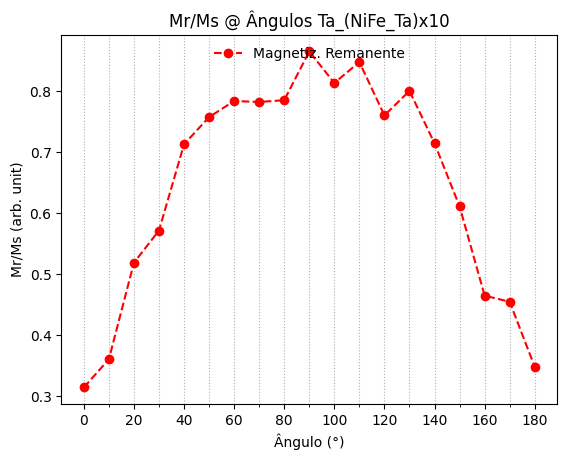

In [62]:
"""
PLOTANDO A MAGNETIZAÇÃO DE REMANÊNCIA (Mr) PARA CADA ÂNGULO
"""

angulos = remanencias.iloc[:, 0].copy() #extrai os angulos -ABQ
magRemanente = remanencias.iloc[:, 1].copy() #extrai os valores de remanencia -ABQ

#plota a magnetização de remanência (Mr) para cada ângulo -ABQ
plt.plot(angulos, magRemanente, "--o", color="red", label="Magnetiz. Remanente")
plt.legend(loc="upper center", frameon=False)

#seta o eixo x de 0 a 180 com ticks de 10 em 10 com espaçamento maior -ABQ
major_ticks = np.arange(0, 181, 20)
plt.xticks(major_ticks)
plt.grid(which="major", axis="x", linestyle=":")

minor_ticks = np.arange(0, 181, 10)
plt.xticks(minor_ticks, minor=True)
plt.grid(which="minor", axis="x", linestyle=":")

# Adiciona rótulos e título
plt.xlabel('Ângulo (°)')
plt.ylabel('Mr/Ms (arb. unit)')
plt.title(f"Mr/Ms @ Ângulos {nomeConcatenadoDaAmostraAlvo}")

# Exibe o gráfico
plt.show()

##### Visualização em gráfico polar

[0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 180 190
 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360]


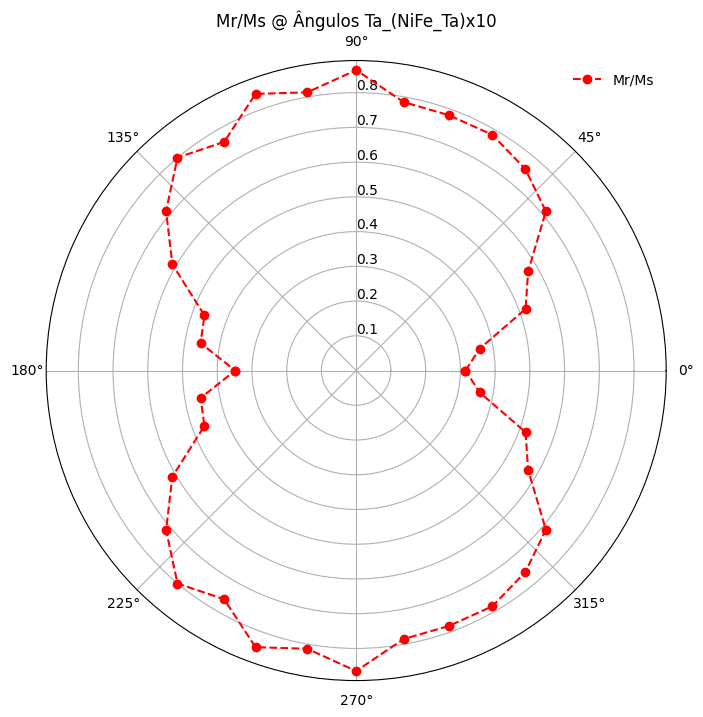

In [63]:
"""
CONSTRUÇÃO DO PLOT POLAR
"""

angulosDup = np.concatenate([angulos, angulos+180]) #duplica os valores de angulos para plotar o gráfico polar -ABQ
print(angulosDup)
magRemanenteDup = np.concatenate((magRemanente, magRemanente[::-1])) #duplica os valores de remanencia para plotar o gráfico polar -ABQ

plt.figure(figsize=(8, 12))
angulosRad = [np.radians(anguloRad) for anguloRad in angulosDup]
ax = plt.subplot(111, polar=True)
ax.plot(angulosRad, magRemanenteDup, "--o", color="red", label="Mr/Ms")
ax.set_rlabel_position(90)
ax.legend(loc="upper right", frameon=False)
plt.title(f"Mr/Ms @ Ângulos {nomeConcatenadoDaAmostraAlvo}")
plt.show()

##### Correção de deslocalmento, caso necessário

In [64]:
"""
DESLOCANDO OS DADOS 10° PARA A DIREITA SE NECESSÁRIO
"""

# Deslocando os dados 10° para a direita

angulosDup = angulosDup+10

"""
DUPLICANDO OS DADOS
"""

# Criando um dicionário para armazenar valores únicos
valores_remanencia_dict = {angulo: valor for angulo, valor in remanenciaDeslocada}

# Atualizando novamente os valores de 0° e 360° após duplicação
if 0 not in valores_remanencia_dict:
    valores_remanencia_dict[0] = valores_remanencia_dict.get(350, valores_remanencia_dict.get(10))
if 360 not in valores_remanencia_dict:
    valores_remanencia_dict[360] = valores_remanencia_dict.get(0, valores_remanencia_dict.get(350))

# Duplicando os dados para 0-360 graus, evitando duplicações para ângulo igual
for angulo, valor_remanencia in list(remanenciaDeslocada):
    if angulo > 0 and angulo < 180:
        angulo_duplicado = 360 - angulo
        if angulo_duplicado not in valores_remanencia_dict:
            valores_remanencia_dict[angulo_duplicado] = valor_remanencia

# Ordenando os valores duplicados por ângulo
valores_remanencia_duplicados = sorted(valores_remanencia_dict.items())

# Separando ângulos e valores de remanência
angulos = [x[0] for x in valores_remanencia_duplicados]
remanencias = [x[1] for x in valores_remanencia_duplicados]

# Convertendo ângulos para radianos para plotagem polar
angulos_rad = np.radians(angulos)



NameError: name 'remanenciaDeslocada' is not defined